# Adding New Sources

A major goal of TDAstro is to be easily extensible so that users can create and analyze their own source models. In this tutorial we look at how a user can add a custom source to simulate an astronomical phenomenon that is not already supported by TDAstro. 

## Creating a new model node

All sources are subclasses of the `PhysicalModel` class in `src/tdastro/sources/physical_models.py`. This class implements a bunch of helper functions to handle parameters and simulate the output of an object, but users only need to override two of them to create a new subclass:

  * The `__init__()` method sets up the parameters.
  * The `compute_flux()` draws effect-free observations for the object.

As discussed in the introduction_demo notebook, all nodes in TDAStro accept dynamic parameterization. These are parameters that change with each sampling run. For example if we have a node modeling the source's output as a sin wave, we may want to include two parameters: the peak `brightness` of the object and the `frequency` of the underlying wave.  We specify both of these parameters with the `ParameterizedNode`'s `add_parameter()` function. Behind the scenes this function does the heavy lifting to understand how the parameter is actually set during each run (from a constant, another `ParameterizedNode`, the computation of a function, etc.).

Consider the example below, which implements the sin wave model.  There are some details in the implementation below that we do not cover immediately (such as the `get_local_params()` function), but will describe below. 

In [1]:
import numpy as np

from tdastro.sources.physical_model import PhysicalModel


class SinSource(PhysicalModel):
    """A source that emits a sine wave:

    flux = brightness * sin(2 * pi * frequency * (time - t0))

    Parameters
    ----------
    brightness : `float`
        The inherent brightness
    frequency : `float`
        The frequence of the sine wave.
    **kwargs : `dict`, optional
        Any additional keyword arguments.
    """

    def __init__(self, brightness, frequency, **kwargs):
        super().__init__(**kwargs)
        self.add_parameter("brightness", brightness, **kwargs)
        self.add_parameter("frequency", frequency, **kwargs)

    def compute_flux(self, times, wavelengths, graph_state, **kwargs):
        """Draw effect-free observations for this object.

        Parameters
        ----------
        times : `numpy.ndarray`
            A length T array of rest frame timestamps.
        wavelengths : `numpy.ndarray`, optional
            A length N array of wavelengths (in angstroms).
        graph_state : `GraphState`
            An object mapping graph parameters to their values.
        **kwargs : `dict`, optional
            Any additional keyword arguments.

        Returns
        -------
        flux_density : `numpy.ndarray`
            A length T x N matrix of SED values (in nJy).
        """
        params = self.get_local_params(graph_state)
        phases = 2.0 * np.pi * params["frequency"] * (times - params["t0"])
        single_wave = params["brightness"] * np.sin(phases)
        return np.tile(single_wave[:, np.newaxis], (1, len(wavelengths)))

As described above the `__init__()` function adds two parameters `brightness` and `frequency`. These are set from the input arguments of the same name, but, as we will see below, could be set by a variety of inputs. In each parameterized node inherits the parameters set by its parent node. For the `PhysicalModel` class this includes: `dec`, `distance`, `ra`, `redshift`, `t0`, and `white_noise_sigma`.

We can create a model node and request information about its settable parameters.

In [2]:
model = SinSource(brightness=15.0, frequency=1.0, t0=0.0)
print(model.list_params())

['ra', 'dec', 'redshift', 't0', 'distance', 'brightness', 'frequency']


### Accessing a Node's Parameters

Each `ParameterizedNode` is stateless by design, so it does **not** store the values for any of its parameters. Instead it stores information on how to get those values when sampled. Thus the `compute_flux()` function must take a `GraphState` object that contains the parameter information. This is usually generated with a call to `sample_parameters()`, but will also be automatically generated internally if the `evaluate()` function is called without this information.

As a natural consequence of this statelessness, the `compute_flux()` function needs to call `self.get_local_params(graph_state)` to extract the current' node's parameters from the `GraphState` object. This function returns a dictionary mapping the parameter's name to its value.

### Evaluating the Node

The actual evaluation (computation of the SED) of the source occurs through the object's `evaluate()` function, which internally calls the `compute_flux()` function. Users of the node should call `evaluate()` since that function performs the necessary pre- and post- computations, such as shifting the wavelengths according to the redshift. The developer of a new source only needs to implement the `compute_flux()` function, though.

**Note:** TDAstro is set up to be modular with the foundation code performing most of the heavy listing. This includes most of the functions in `PhysicalModel`, because the base class is set up to consistently apply transformations and effects to all its subclasses.  New effects can be added by creating new subclasses of `EffectModel`. Thus the developers of new sources should avoid overloading or modifying the `evaluate()` function unless they need to fundamentally change how effects are applied.

Text(0, 0.5, 'Flux Density')

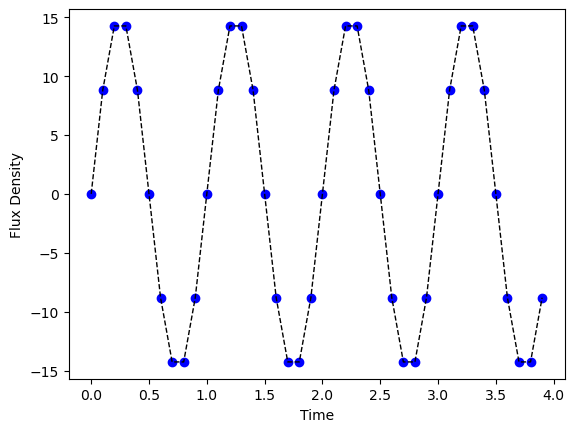

In [3]:
import matplotlib.pyplot as plt

times = np.arange(0, 4.0, 0.1)
wavelengths = np.array([100.0, 200.0])

values = model.evaluate(times, wavelengths)

plt.plot(times, values[:, 0], color="blue", marker="o", linewidth=0)
plt.plot(times, 15.0 * np.sin(2.0 * np.pi * times), color="black", linewidth=1, linestyle="--", markersize=0)
plt.xlabel("Time")
plt.ylabel("Flux Density")

Here our new `SinSource` is sampling the parameters to create a `GraphState` object and then passing that through to `compute_flux()` to produce a T by W matrix where T is the number of times to sample and W is the number of wavelengths to sample.

If our node's parameters are not constant, such as brightness being generated randomly [10.0, 11.0], then we will get different results each time we call `evaluate()`.

Next we use TDAstro's built-in `NumpyRandomFunc` node to generate the input for another node's parameter. The underlying source is still the same `SinSource` class. However we have changed how we specify the parameter. Instead of assigning a constant, we assign the **output** of another node. In this case, the `NumpyRandomFunc` node wraps numpy's random number generator and returns samples from it. As shown in the plot each of the samples comes from a sin wave with a different brightness (max value) and frequency.  The legend shows the values for each curve.

Text(0, 0.5, 'Flux Density')

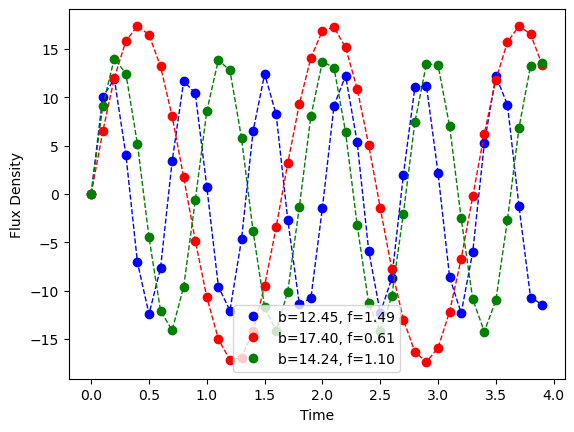

In [4]:
from tdastro.math_nodes.np_random import NumpyRandomFunc

model = SinSource(
    brightness=NumpyRandomFunc("uniform", low=10.0, high=20.0),
    frequency=NumpyRandomFunc("uniform", low=0.5, high=1.5),
    t0=0.0,
    node_label="model",
)

# Plot three random draws from the model
for idx, color in enumerate(["blue", "red", "green"]):
    sample = model.sample_parameters()

    # Extract the sampled parameters to use in the legend
    brightness = sample["model"]["brightness"]
    frequency = sample["model"]["frequency"]

    # Evaluate the model (using the sampled parameters) and plot the result.
    values = model.evaluate(times, wavelengths, sample)
    plt.plot(
        times,
        values[:, 0],
        color=color,
        marker="o",
        linewidth=0,
        label=f"b={brightness:.2f}, f={frequency:.2f}",
    )
    plt.plot(
        times,
        brightness * np.sin(2.0 * np.pi * frequency * times),
        color=color,
        linewidth=1,
        linestyle="--",
        markersize=0,
    )
plt.legend()
plt.xlabel("Time")
plt.ylabel("Flux Density")

## Using Internal Functions

In the last example above, we used the `NumpyRandomFunc` node to generate a uniform value from [10.0, 11.0]. This provides an example of how nodes in the graph can depend on each other. But what about cases where some information in the node depends on other information provided to the node?

An example of this might be a model of an AGN where the parameterization depends on the mass of the central blackhole (`blackhole_mass`).  We define another parameter as a function of that given parameter: `accretion_rate` is computed from the blackhole mass. For this second parameter, we feed information from other parameters into a function and return the result. 

TDAstro's `FunctionNode` class provides a wrapper for such functions. The constructor takes in the function and a list of parameters. It can then be referenced directly to use its output to set parameters in other parts of the model. While the function we show below is simple (only one variable), we can use these types of function nodes to capture complex interactions.  For example the `PhysicalModel` function has the ability to compute an estimated distance from a given redshift and cosmological model.

In [5]:
from astropy import constants
from tdastro.base_models import FunctionNode


class ToyAGN(PhysicalModel):
    """A toy AGN model.

    Parameters
    ----------
    blackhole_mass : float
        The black hole mass in g.
    **kwargs : `dict`, optional
        Any additional keyword arguments.
    """

    def __init__(self, blackhole_mass, **kwargs):
        super().__init__(**kwargs)

        # Add the given parameters.
        self.add_parameter("blackhole_mass", blackhole_mass, **kwargs)

        # Add the derived parameters using FunctionNodes built from the object's methods.
        # Each of these will be computed for each sample value of the input parameters.
        self.add_parameter(
            "accretion_rate",
            FunctionNode(self._compute_accretion_rate, blackhole_mass=self.blackhole_mass),
            **kwargs,
        )

    def _compute_accretion_rate(self, blackhole_mass):
        return 1.4e18 * blackhole_mass / constants.M_sun.cgs.value

    def compute_flux(self, times, wavelengths, graph_state, **kwargs):
        """Draw effect-free observations for this object.

        Parameters
        ----------
        times : `numpy.ndarray`
            A length T array of rest frame timestamps.
        wavelengths : `numpy.ndarray`, optional
            A length N array of wavelengths (in angstroms).
        graph_state : `GraphState`
            An object mapping graph parameters to their values.
        **kwargs : `dict`, optional
            Any additional keyword arguments.

        Returns
        -------
        flux_density : `numpy.ndarray`
            A length T x N matrix of SED values (in nJy).
        """
        params = self.get_local_params(graph_state)
        return np.full((len(times), len(wavelengths)), params["accretion_rate"])

To see how this works, let's create a model where the blackhole mass is generated using a Gaussian distribution (centered on 1000x the sun's mass with a standard deviation of 50) and look at the sampled parameters.

In [6]:
agn_model = ToyAGN(
    blackhole_mass=NumpyRandomFunc(
        "normal", loc=1000.0 * constants.M_sun.cgs.value, scale=50.0 * constants.M_sun.cgs.value
    ),
    node_label="toy_agn",
)

samples = agn_model.sample_parameters(num_samples=5)
print(samples)

toy_agn:
    ra: [None None None None None]
    dec: [None None None None None]
    redshift: [None None None None None]
    t0: [None None None None None]
    distance: [None None None None None]
    blackhole_mass: [2.04332737e+36 2.01214923e+36 2.04518770e+36 1.94736175e+36
 1.88359976e+36]
    accretion_rate: [1.43866632e+21 1.41671441e+21 1.43997614e+21 1.37109883e+21
 1.32620528e+21]
NumpyRandomFunc:normal_1:
    loc: [1.98840987e+36 1.98840987e+36 1.98840987e+36 1.98840987e+36
 1.98840987e+36]
    scale: [9.94204935e+34 9.94204935e+34 9.94204935e+34 9.94204935e+34
 9.94204935e+34]
    function_node_result: [2.04332737e+36 2.01214923e+36 2.04518770e+36 1.94736175e+36
 1.88359976e+36]
FunctionNode:_compute_accretion_rate_2:
    blackhole_mass: [2.04332737e+36 2.01214923e+36 2.04518770e+36 1.94736175e+36
 1.88359976e+36]
    function_node_result: [1.43866632e+21 1.41671441e+21 1.43997614e+21 1.37109883e+21
 1.32620528e+21]


What we see in the output is list of nodes, each with a corresponding list of parameters with one entry for each sample. The entries under the node=`toy_agn` and parameter=`blackhole_mass` show the five **independent** samples generated for the blackhole mass by the Gaussian function. Each of these serves as top level input to the model.  Note that some of the parameters are `None`, such as the source's RA, dec, distance, and redshift, because we did not set them.

In contrast to parameters like `blackhole_mass` which are generated independently from a Gaussian, other parameters are generated conditioned on existing parameters in the model. Consider the relationship between the input data and the accretion rate. From the `_compute_accretion_rate()` function, we can see that the accretion rate is proportional to the blackhole mass.  The values of each `accretion_rate` sample is set **deterministically** from the corresponding sample of the `blackhole_mass`. In other words, the parameters for each sample are mathematically consistent within the sample.

Note that in addition to explicitly provided parameters we can see inherited parameters (e.g. `toy_agn.ra`) and internal bookkeeping parameters. An example of the latter type is the parameter `function_node_result` which stores a function's computed results so it can be passed to later nodes.

## More Complex Compute Functions

The heart of each source is it's `compute_flux()` function, which determines how the node is actually simulated.

While the examples above are relatively simplistic (a sin wave or a constant output), we can made arbitrarily complicated sources. We suggest that developers of new models to look at the examples in `src/tdastro/sources/` for examples.